In [1]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


### define the function to validate the result we get

In [3]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

# pre experiment
this section checks if all the codes runs correctly.

## baseline
the original version: stencil2d_orig. 

Neither mpi nor omp is implemented.

In [4]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=orig

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-orig.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-orig.o -o stencil2d-orig.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-orig.x' (lite-samples) ...OK


cp stencil2d-orig.x stencil2d.x


In [5]:
%%bash
srun -n 2 -c 6 ./stencil2d-orig.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_baseline.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


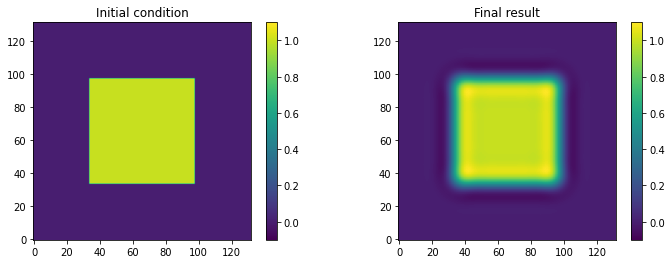

In [6]:
validate_results()

## Implement mpi

In [7]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=mpi

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-mpi.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-mpi.o -o stencil2d-mpi.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-mpi.x' (lite-samples) ...OK


cp stencil2d-mpi.x stencil2d.x


In [9]:
%%bash
srun -n 2 -c 6 ./stencil2d-mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_mpi.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


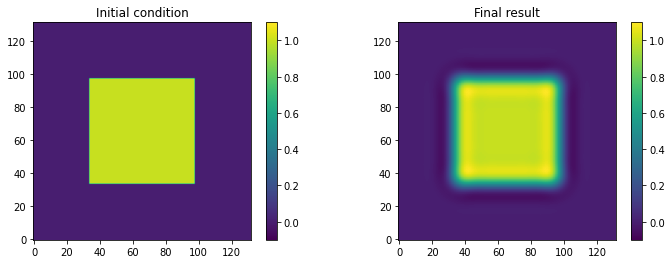

In [10]:
validate_results()

## mpi + omp
using mpi to decompose the domain, and using omp to parallel k-loop

In [11]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=omp

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-omp.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-omp.o -o stencil2d-omp.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-omp.x' (lite-samples) ...OK


cp stencil2d-omp.x stencil2d.x


In [12]:
%%bash
export OMP_NUM_THREADS=6
srun -n 2 -c 6 ./stencil2d-omp.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_omp.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


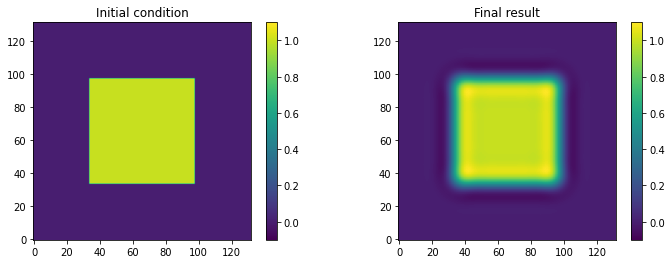

In [13]:
validate_results()

## mpi + omp + kblock
mpi + omp, plus using k-block strategy in k-loop.

In [14]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=kblock

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kblock.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-kblock.o -o stencil2d-kblock.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-kblock.x' (lite-samples) ...OK


cp stencil2d-kblock.x stencil2d.x


In [15]:
%%bash
export OMP_NUM_THREADS=6
srun -n 2 -c 6 ./stencil2d-kblock.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_kblock.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


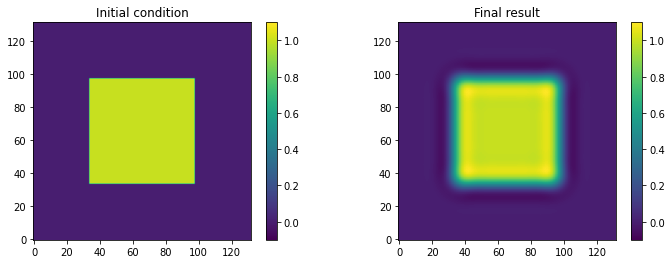

In [16]:
validate_results()

## inline
mpi + omp + kblock implemented.

the laplacian() function is also inlined.

In [17]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=kblockin

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kblockin.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-kblockin.o -o stencil2d-kblockin.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-kblockin.x' (lite-samples) ...OK


cp stencil2d-kblockin.x stencil2d.x


In [18]:
%%bash
export OMP_NUM_THREADS=6
srun -n 2 -c 6 ./stencil2d-kblockin.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_kblockin.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


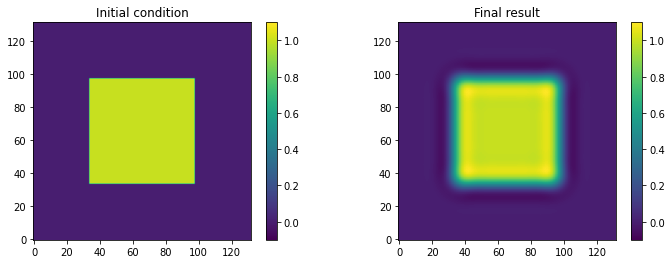

In [19]:
validate_results()

## on the fly

the previous codes all use pre-computation strategy, which means that a temporary field storing the first laplacian is first computed before the second laplacian is computed. On the contrary, this on-the-fly version combines two laplacian, and no temporary field is computed or stored.

In [20]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=onfly

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-onfly.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-onfly.o -o stencil2d-onfly.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-onfly.x' (lite-samples) ...OK


cp stencil2d-onfly.x stencil2d.x


In [21]:
%%bash
export OMP_NUM_THREADS=6
srun -n 2 -c 6 ./stencil2d-onfly.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_mpi_onfly.txt

CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


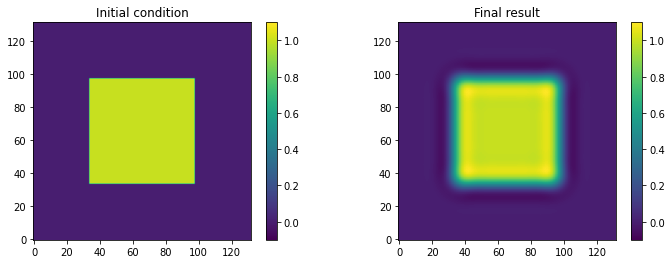

In [22]:
validate_results()

# Formal experiment (1 node)

## default dimension (128\*128\*64)

### baseline

In [81]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


In [1]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=orig

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_partitioner.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-orig.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-orig.o -o stencil2d-orig.x
cp stencil2d-orig.x stencil2d.x


In [6]:
%%bash
rm outputs/out_baseline.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_baseline.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-orig.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_baseline.txt
  done
done

srun: Job 48860546 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Job 48860546 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Job 48860546 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48860546
srun: Step created for job 48860546
srun: Job 48860546 step creation still disabled, retrying (Requested nodes are busy)
srun: Job 48860546 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Job 48860546 step creation still disabled, retrying (Requested nodes are busy)
srun: Step created for job 48860546
srun: Job 48860546 step creation still disabled, retrying (Requested nodes are busy)
srun: Job 48860546 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Job 48860546 step creation still disabled, retrying (Requested nodes are busy)
srun: Job 48860546 step creation still disabled, retrying (Requested nodes are busy)
srun: Job 48

Error while terminating subprocess (pid=16137): 


In [4]:
exec(open("outputs/out_baseline.txt", "r").read())

NameError: name 'np' is not defined

### mpi

In [19]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=mpi

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-mpi.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-mpi.o -o stencil2d-mpi.x
cp stencil2d-mpi.x stencil2d.x


In [20]:
%%bash
rm outputs/out_mpi.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_mpi.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_mpi.txt
  done
done

rm: cannot remove 'out_mpi.txt': No such file or directory
srun: Job 48087435 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48087435
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.


### omp

In [2]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=omp

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-omp.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-omp.o -o stencil2d-omp.x
cp stencil2d-omp.x stencil2d.x


In [51]:
%%bash
srun -n 2 -c 6 ./stencil2d-omp.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > outputs/out_omp.txt

In [52]:
%%bash
rm outputs/out_omp.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_omp.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-omp.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_omp.txt
  done
done

srun: Job 48072729 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48072729
srun: Job 48072729 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48072729
srun: Job 48072729 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48072729
srun: Job 48072729 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48072729
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU reso

### kblock

In [6]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=kblock

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kblock.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-kblock.o -o stencil2d-kblock.x
cp stencil2d-kblock.x stencil2d.x


In [7]:
%%bash
srun -n 2 -c 6 ./stencil2d-kblock.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > outputs/out_kblock.txt

In [8]:
%%bash
rm outputs/out_kblock.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblock.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-kblock.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_kblock.txt
  done
done

oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OM

### kblock-inline

In [11]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=kblockin

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kblockin.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-kblockin.o -o stencil2d-kblockin.x
cp stencil2d-kblockin.x stencil2d.x


In [12]:
%%bash
srun -n 2 -c 6 ./stencil2d-kblockin.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > outputs/out_kblockin.txt

In [13]:
%%bash
rm outputs/out_kblockin.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblockin.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-kblockin.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_kblockin.txt
  done
done

srun: Job 48087435 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48087435
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print 

### onfly

In [14]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=onfly

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-onfly.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o m_partitioner.o stencil2d-onfly.o -o stencil2d-onfly.x
cp stencil2d-onfly.x stencil2d.x


In [15]:
%%bash
srun -n 2 -c 6 ./stencil2d-onfly.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > outputs/out_onfly.txt

In [16]:
%%bash
rm outputs/out_onfly.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_onfly.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-onfly.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_onfly.txt
  done
done

oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OM

## increase dimension (512\*512\*64)

In [36]:
%%bash
rm outputs/out_mpi512.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_mpi512.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-mpi.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_mpi512.txt
  done
done

rm: cannot remove 'out_mpi512.txt': No such file or directory
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.


In [3]:
%%bash
rm outputs/out_omp512.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_omp512.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-omp.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_omp512.txt
  done
done

srun: Job 48089163 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089163
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print 

In [4]:
%%bash
rm outputs/out_kblock512.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblock512.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-kblock.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_kblock512.txt
  done
done

oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OM

In [18]:
%%bash
rm outputs/out_kblockin512.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblockin512.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-kblockin.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_kblockin512.txt
  done
done

rm: cannot remove 'out_kblockin512.txt': No such file or directory
srun: Job 48087435 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48087435
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE t

In [21]:
%%bash
rm out_onfly512.txt
ranks=(2 3 4 6 8 12)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((24/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_onfly512.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -n $nrank -c $ncores ./stencil2d-onfly.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_onfly512.txt
  done
done

rm: cannot remove 'out_onfly512.txt': No such file or directory
srun: Job 48087435 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48087435
srun: Job 48087435 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48087435
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
o

## plot results

### 128 \*  128 \* 64, N_node=1

In [32]:
cases = ["mpi", "omp", "kblock", "kblockin", "onfly"]
num_ranks = [2, 3, 4, 6, 8, 12]
results = dict()
for case in cases:
    results[case] = []
    exec(open("outputs/out_%s.txt" % case, "r").read())
    for rank in num_ranks:
        results[case].append(eval("out_%d" % rank))
results_for_plot = dict()
for case in cases:
    results_for_plot[case] = []
    for i in range(len(num_ranks)):
        results_for_plot[case].append([])
        for j in range(1, len(results[case][i])):
            results_for_plot[case][i].append(results[case][i][j][0, 5])

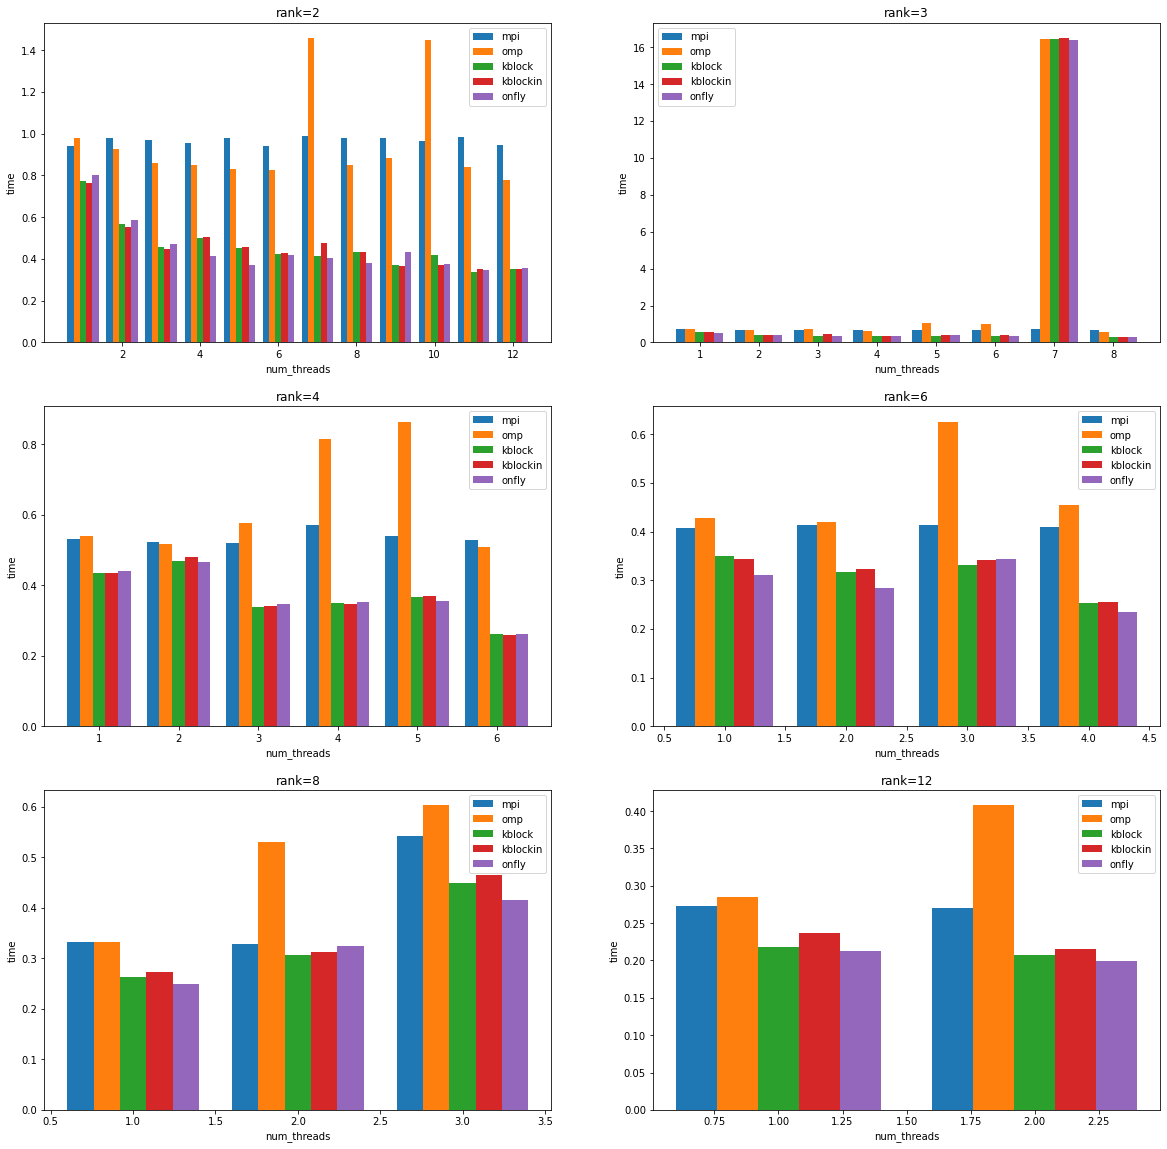

In [34]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
for i in range(len(num_ranks)):
    n_threads = np.arange(24 / num_ranks[i]) + 1
    total_width = 0.8
    for j in range(len(cases)):
        each_width = total_width/len(cases)
        xj = n_threads - total_width/2 + each_width * (j + 1/2)
        yj = results_for_plot[cases[j]][i]
        axs.flat[i].bar(xj, yj, each_width, label=cases[j])
    axs.flat[i].set_title("rank=%d" % num_ranks[i])
    axs.flat[i].set_xlabel("num_threads")
    axs.flat[i].set_ylabel("time")
    axs.flat[i].legend()
plt.show()

### 512 \* 512 \* 64, N_node = 1

In [5]:
cases = ["mpi", "omp", "kblock", "kblockin", "onfly"]
num_ranks = [2, 3, 4, 6, 8, 12]
results = dict()
for case in cases:
    results[case] = []
    exec(open("outputs/out_%s512.txt" % case, "r").read())
    for rank in num_ranks:
        results[case].append(eval("out_%d" % rank))
results_for_plot = dict()
for case in cases:
    results_for_plot[case] = []
    for i in range(len(num_ranks)):
        results_for_plot[case].append([])
        for j in range(1, len(results[case][i])):
            results_for_plot[case][i].append(results[case][i][j][0, 5])

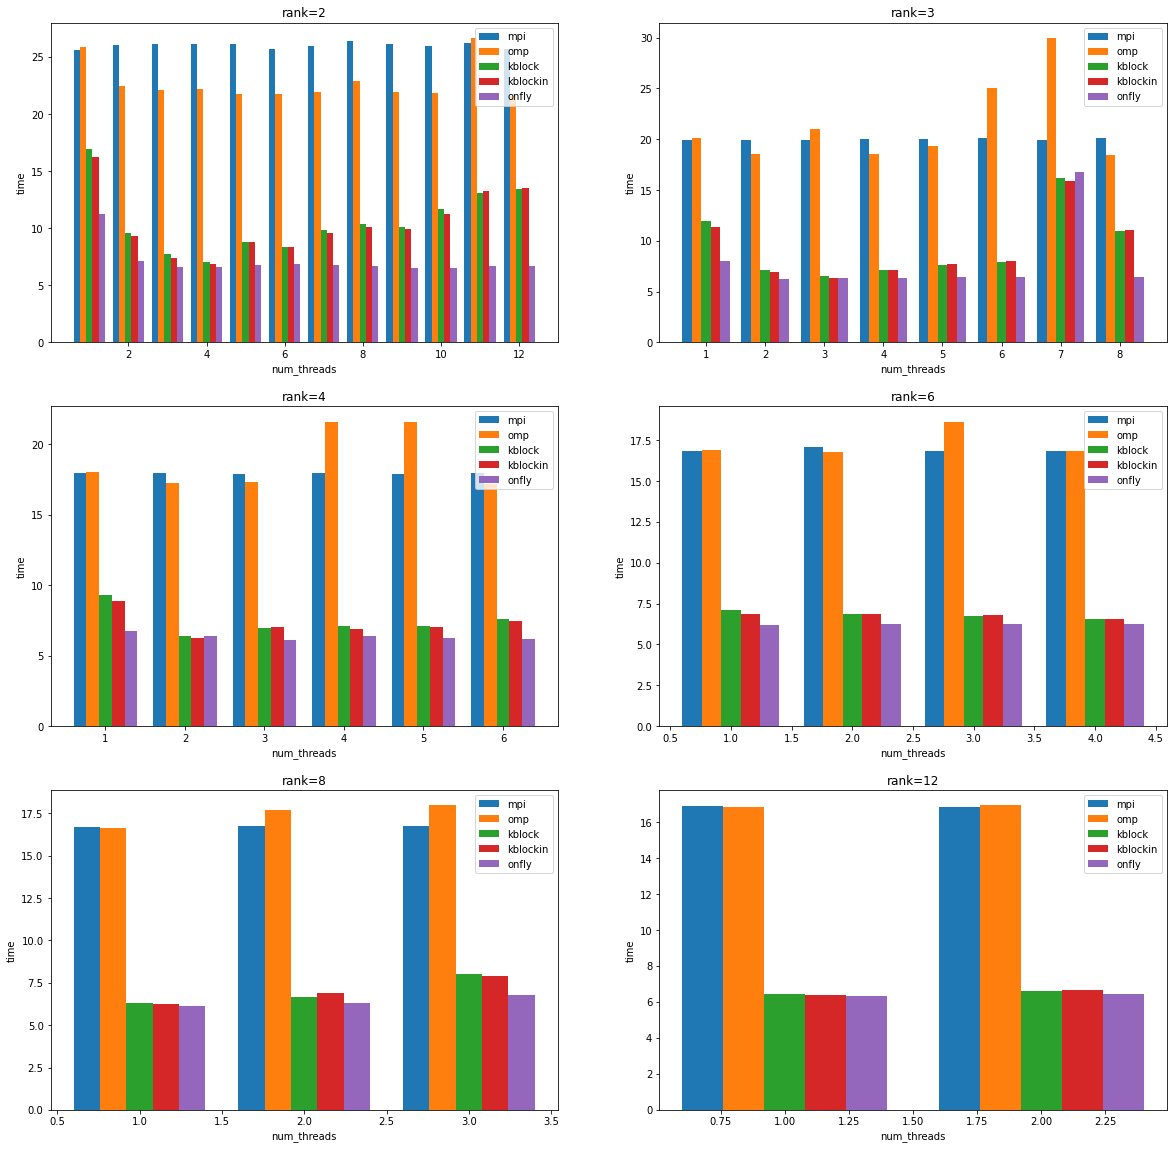

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
for i in range(len(num_ranks)):
    n_threads = np.arange(24 / num_ranks[i]) + 1
    total_width = 0.8
    for j in range(len(cases)):
        each_width = total_width/len(cases)
        xj = n_threads - total_width/2 + each_width * (j + 1/2)
        yj = results_for_plot[cases[j]][i]
        axs.flat[i].bar(xj, yj, each_width, label=cases[j])
    axs.flat[i].set_title("rank=%d" % num_ranks[i])
    axs.flat[i].set_xlabel("num_threads")
    axs.flat[i].set_ylabel("time")
    axs.flat[i].legend()
plt.show()

# Formal experiment, N_node = 2

## dimension: 512\*512\*64

In [1]:
%%bash
rm outputs/out_mpi512N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_mpi512N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-mpi.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_mpi512N2.txt
  done
done

rm: cannot remove 'out_mpi512N2.txt': No such file or directory
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335


In [3]:
%%bash
rm outputs/out_omp512N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_omp512N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-omp.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_omp512N2.txt
  done
done

rm: cannot remove 'out_omp512N2.txt': No such file or directory


In [4]:
%%bash
rm outputs/out_kblock512N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblock512N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-kblock.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_kblock512N2.txt
  done
done

rm: cannot remove 'out_kblock512N2.txt': No such file or directory
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335


In [5]:
%%bash
rm outputs/out_kblockin512N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblockin512N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-kblockin.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_kblockin512N2.txt
  done
done

rm: cannot remove 'out_kblockin512N2.txt': No such file or directory
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335


In [6]:
%%bash
rm outputs/out_onfly512N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_onfly512N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-onfly.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_onfly512N2.txt
  done
done

rm: cannot remove 'out_onfly512N2.txt': No such file or directory
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335
srun: Job 48089335 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48089335


### plot

In [13]:
cases = ["mpi", "omp", "kblock", "kblockin", "onfly"]
num_ranks = [2, 4, 6, 8, 12, 24]
results = dict()
for case in cases:
    results[case] = []
    exec(open("outputs/out_%s512N2.txt" % case, "r").read())
    for rank in num_ranks:
        results[case].append(eval("out_%d" % rank))
results_for_plot = dict()
for case in cases:
    results_for_plot[case] = []
    for i in range(len(num_ranks)):
        results_for_plot[case].append([])
        for j in range(1, len(results[case][i])):
            results_for_plot[case][i].append(results[case][i][j][0, 5])

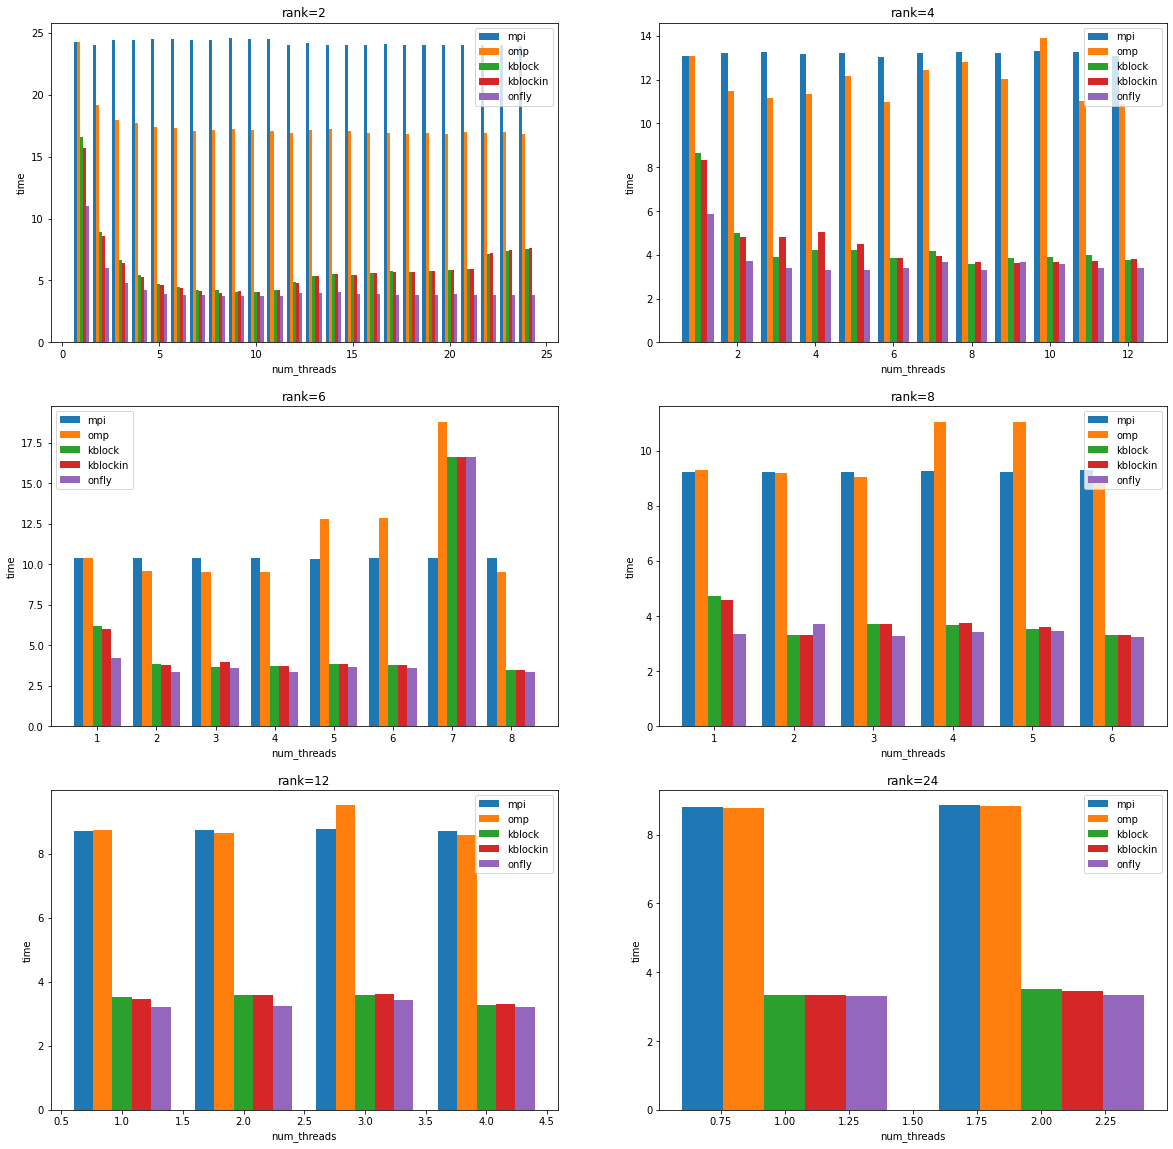

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
for i in range(len(num_ranks)):
    n_threads = np.arange(48 / num_ranks[i]) + 1
    total_width = 0.8
    for j in range(len(cases)):
        each_width = total_width/len(cases)
        xj = n_threads - total_width/2 + each_width * (j + 1/2)
        yj = results_for_plot[cases[j]][i]
        axs.flat[i].bar(xj, yj, each_width, label=cases[j])
    axs.flat[i].set_title("rank=%d" % num_ranks[i])
    axs.flat[i].set_xlabel("num_threads")
    axs.flat[i].set_ylabel("time")
    axs.flat[i].legend()
plt.show()

## dimension: 1024 \* 1024 \* 64

In [ ]:
%%bash
rm outputs/out_mpi512N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_mpi512N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-mpi.x --nx 512 --ny 512 --nz 64 --num_iter 1024 >> outputs/out_mpi512N2.txt
  done
done

In [9]:
%%bash
rm outputs/out_omp1024N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_omp1024N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-omp.x --nx 1024 --ny 1024 --nz 64 --num_iter 1024 >> outputs/out_omp1024N2.txt
  done
done

srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Job 48090128 step creation still disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step cr

In [2]:
%%bash
rm outputs/out_kblock1024N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblock1024N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-kblock.x --nx 1024 --ny 1024 --nz 64 --num_iter 1024 >> outputs/out_kblock1024N2.txt
  done
done

rm: cannot remove 'out_kblock1024N2.txt': No such file or directory
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128


In [1]:
%%bash
rm outputs/out_onfly1024N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_onfly1024N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-onfly.x --nx 1024 --ny 1024 --nz 64 --num_iter 1024 >> outputs/out_onfly1024N2.txt
  done
done

rm: cannot remove 'out_onfly1024N2.txt': No such file or directory
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128


In [20]:
cases = ["omp", "kblock", "onfly"]
num_ranks = [2, 4, 6, 8, 12, 24]
results = dict()
for case in cases:
    results[case] = []
    exec(open("outputs/out_%s1024N2.txt" % case, "r").read())
    for rank in num_ranks:
        results[case].append(eval("out_%d" % rank))
results_for_plot = dict()
for case in cases:
    results_for_plot[case] = []
    for i in range(len(num_ranks)):
        results_for_plot[case].append([])
        for j in range(1, len(results[case][i])):
            results_for_plot[case][i].append(results[case][i][j][0, 5])

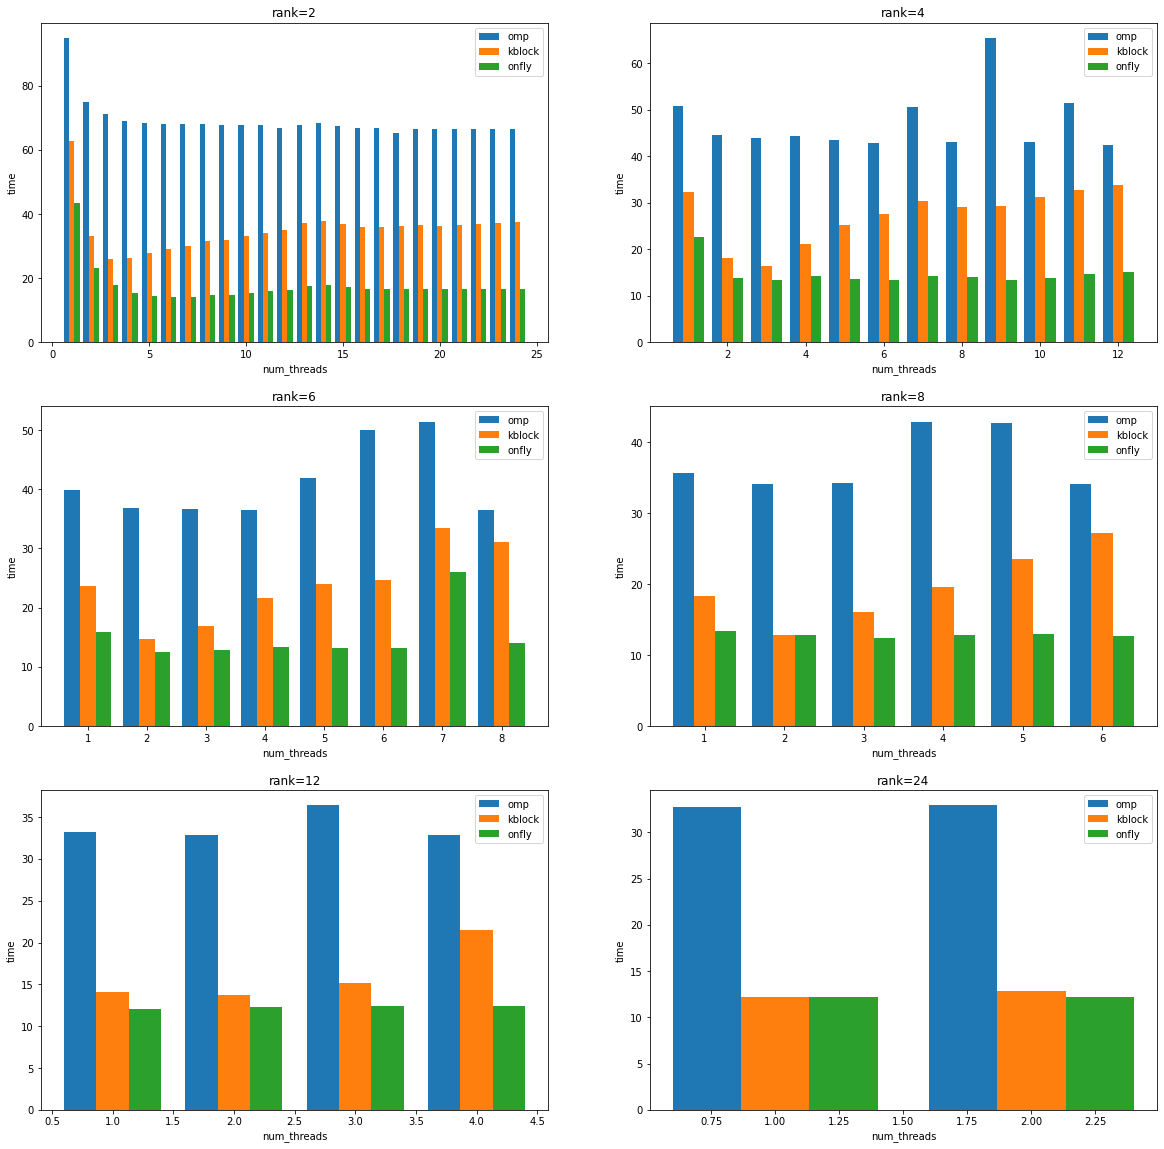

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
for i in range(len(num_ranks)):
    n_threads = np.arange(48 / num_ranks[i]) + 1
    total_width = 0.8
    for j in range(len(cases)):
        each_width = total_width/len(cases)
        xj = n_threads - total_width/2 + each_width * (j + 1/2)
        yj = results_for_plot[cases[j]][i]
        axs.flat[i].bar(xj, yj, each_width, label=cases[j])
    axs.flat[i].set_title("rank=%d" % num_ranks[i])
    axs.flat[i].set_xlabel("num_threads")
    axs.flat[i].set_ylabel("time")
    axs.flat[i].legend()
plt.show()

## dimension: 64 \* 64 \* 64

In [12]:
%%bash
rm outputs/out_mpi64N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_mpi64N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-mpi.x --nx 64 --ny 64 --nz 64 --num_iter 1024 >> outputs/out_mpi64N2.txt
  done
done

rm: cannot remove 'out_mpi64N2.txt': No such file or directory
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128


In [13]:
%%bash
rm outputs/out_omp64N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_omp64N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-omp.x --nx 64 --ny 64 --nz 64 --num_iter 1024 >> outputs/out_omp64N2.txt
  done
done

rm: cannot remove 'out_omp64N2.txt': No such file or directory
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128


In [14]:
%%bash
rm outputs/out_kblock64N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblock64N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-kblock.x --nx 64 --ny 64 --nz 64 --num_iter 1024 >> outputs/out_kblock64N2.txt
  done
done

rm: cannot remove 'out_kblock64N2.txt': No such file or directory
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128


In [16]:
%%bash
rm outputs/out_kblockin64N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblockin64N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-kblockin.x --nx 64 --ny 64 --nz 64 --num_iter 1024 >> outputs/out_kblockin64N2.txt
  done
done

rm: cannot remove 'out_kblockin64N2.txt': No such file or directory
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128


In [15]:
%%bash
rm outputs/out_onfly64N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_onfly64N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-onfly.x --nx 64 --ny 64 --nz 64 --num_iter 1024 >> outputs/out_onfly64N2.txt
  done
done

rm: cannot remove 'out_onfly64N2.txt': No such file or directory
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128
srun: Job 48090128 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48090128


In [17]:
cases = ["mpi", "omp", "kblock", "kblockin", "onfly"]
num_ranks = [2, 4, 6, 8, 12, 24]
results = dict()
for case in cases:
    results[case] = []
    exec(open("outputs/out_%s64N2.txt" % case, "r").read())
    for rank in num_ranks:
        results[case].append(eval("out_%d" % rank))
results_for_plot = dict()
for case in cases:
    results_for_plot[case] = []
    for i in range(len(num_ranks)):
        results_for_plot[case].append([])
        for j in range(1, len(results[case][i])):
            results_for_plot[case][i].append(results[case][i][j][0, 5])

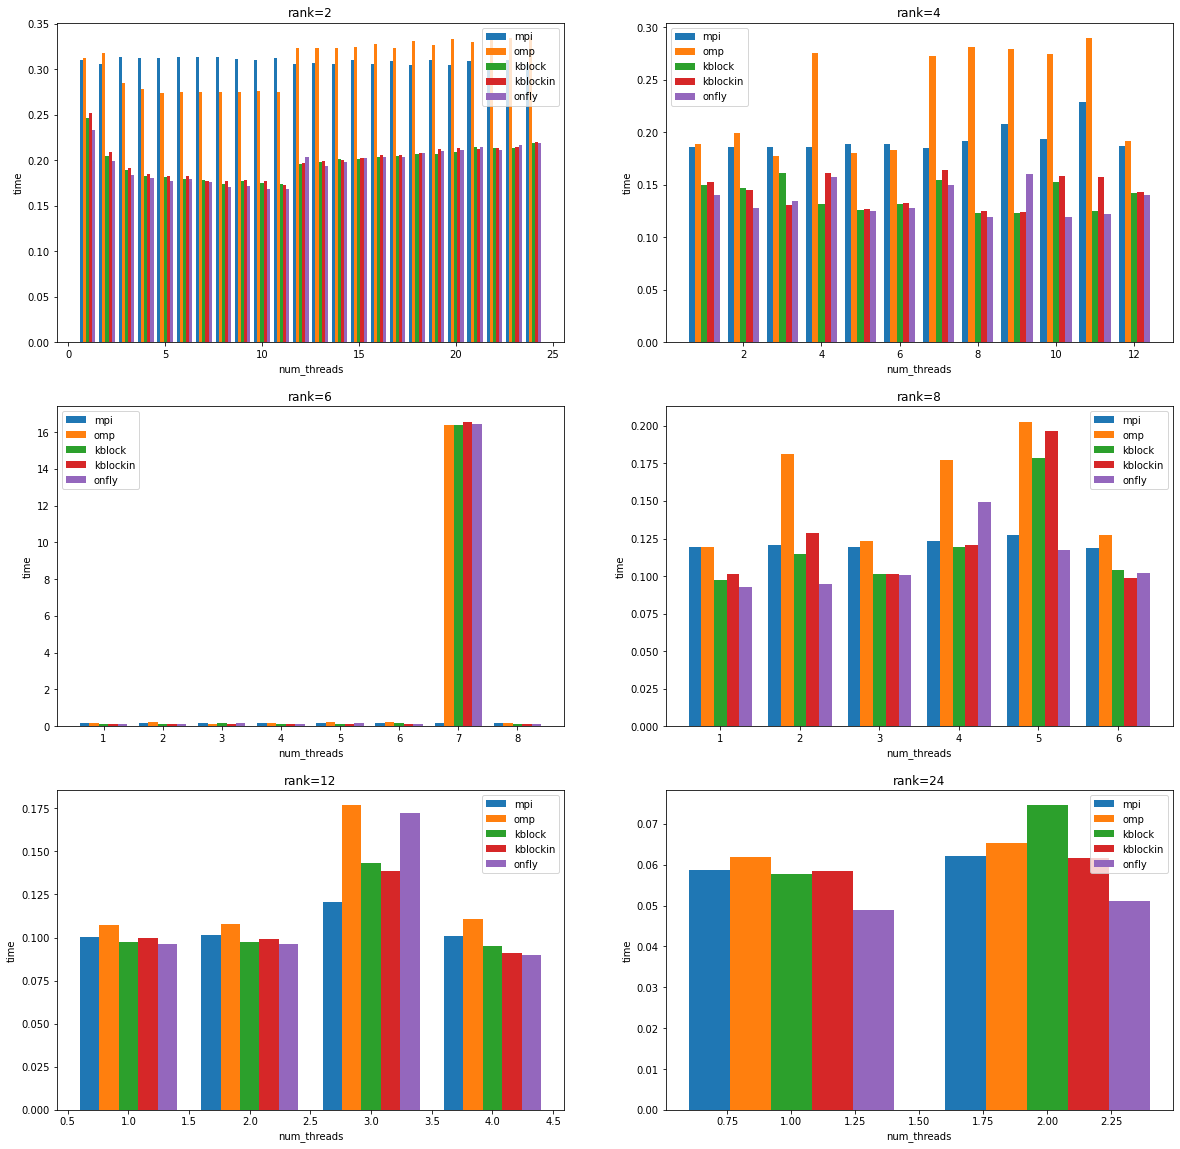

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
for i in range(len(num_ranks)):
    n_threads = np.arange(48 / num_ranks[i]) + 1
    total_width = 0.8
    for j in range(len(cases)):
        each_width = total_width/len(cases)
        xj = n_threads - total_width/2 + each_width * (j + 1/2)
        yj = results_for_plot[cases[j]][i]
        axs.flat[i].bar(xj, yj, each_width, label=cases[j])
    axs.flat[i].set_title("rank=%d" % num_ranks[i])
    axs.flat[i].set_xlabel("num_threads")
    axs.flat[i].set_ylabel("time")
    axs.flat[i].legend()
plt.show()

## dimension: 128 \* 128 \* 64

In [3]:
%%bash
rm outputs/out_mpi128N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_mpi128N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_mpi128N2.txt
  done
done

srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077


In [4]:
%%bash
rm outputs/out_omp128N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_omp128N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-omp.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_omp128N2.txt
  done
done

rm: cannot remove 'out_omp128N2.txt': No such file or directory
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077


In [5]:
%%bash
rm outputs/out_kblock128N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblock128N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-kblock.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_kblock128N2.txt
  done
done

rm: cannot remove 'out_kblock128N2.txt': No such file or directory
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077


In [6]:
%%bash
rm outputs/out_kblockin128N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_kblockin128N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-kblockin.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_kblockin128N2.txt
  done
done

rm: cannot remove 'out_kblockin128N2.txt': No such file or directory
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077


In [7]:
%%bash
rm outputs/out_onfly128N2.txt
ranks=(2 4 6 8 12 24)
for index in ${!ranks[*]} ; do
  nrank=${ranks[$index]}
  max_thread=$((48/$nrank))
  echo "out_$nrank = [None] * ($max_thread+1)" >> outputs/out_onfly128N2.txt
  for nthreads in `seq 1 $max_thread` ; do
    export OMP_NUM_THREADS=$nthreads
    ncores=$nthreads
    if [ $nthreads -gt 24 ] ; then
      ncores=24
    fi
    srun -N 2 -n $nrank -c $ncores ./stencil2d-onfly.x --nx 128 --ny 128 --nz 64 --num_iter 1024 >> outputs/out_onfly128N2.txt
  done
done

rm: cannot remove 'out_onfly128N2.txt': No such file or directory
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077
srun: Job 48092077 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 48092077


In [8]:
cases = ["mpi", "omp", "kblock", "kblockin", "onfly"]
num_ranks = [2, 4, 6, 8, 12, 24]
results = dict()
for case in cases:
    results[case] = []
    exec(open("outputs/out_%s128N2.txt" % case, "r").read())
    for rank in num_ranks:
        results[case].append(eval("out_%d" % rank))
results_for_plot = dict()
for case in cases:
    results_for_plot[case] = []
    for i in range(len(num_ranks)):
        results_for_plot[case].append([])
        for j in range(1, len(results[case][i])):
            results_for_plot[case][i].append(results[case][i][j][0, 5])

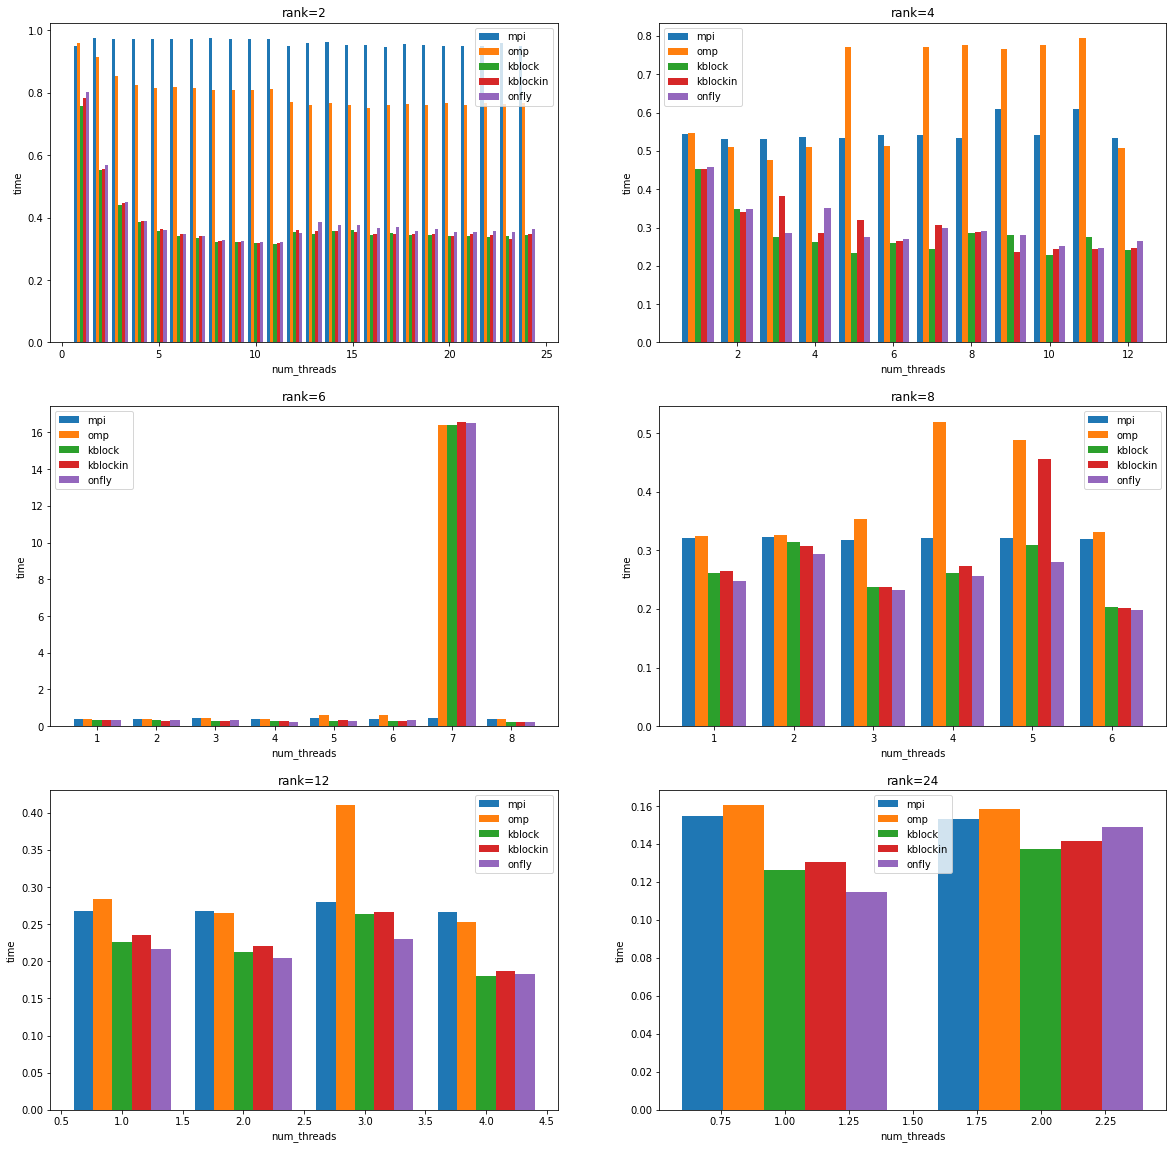

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
for i in range(len(num_ranks)):
    n_threads = np.arange(48 / num_ranks[i]) + 1
    total_width = 0.8
    for j in range(len(cases)):
        each_width = total_width/len(cases)
        xj = n_threads - total_width/2 + each_width * (j + 1/2)
        yj = results_for_plot[cases[j]][i]
        axs.flat[i].bar(xj, yj, each_width, label=cases[j])
    axs.flat[i].set_title("rank=%d" % num_ranks[i])
    axs.flat[i].set_xlabel("num_threads")
    axs.flat[i].set_ylabel("time")
    axs.flat[i].legend()
plt.show()